In [9]:
import json
import sys
import warnings
import os

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Set the working directory to the opt directory
current_dir = os.getcwd() 
parent_dir = os.path.dirname(current_dir)
os.chdir(parent_dir + "/opt")

from data_process import DataProcessor


warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from ev_opt import EV_Opt
from ev_eval import EVChargerEquityEvaluation

output_dir = "../output/exsiting_disparity/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# set arial
matplotlib.rcParams["font.family"] = "sans-serif"
matplotlib.rcParams["font.sans-serif"] = ["Arial"]

# Read Data

In [ ]:
k = 4
data_processor = DataProcessor()
# set demographic partition based on Quartiles
kwargs = {
    "income_bins": k,
    "mud_bins": k,
    "employment_bins": k,
}
# three dfs respectively: demographic data, commute matrix, and vmt flow matrix
df1, df2, df3 = data_processor.process_demo_data(**kwargs)

# set crs to 3857 (from spherical to flat)
df1.crs = "EPSG:4326"
df1 = df1.to_crs("EPSG:3857")

In [ ]:
n_trip_ij = df2.values
n_trip_ij_pct = n_trip_ij / n_trip_ij.sum(axis=0)[:, None]
# n_ij / work_popu[j]
n_trip_ij_pct1 = n_trip_ij / df1["work_popu_LODES"].values[:, None]

n_trip_ij_pct == n_trip_ij_pct1

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]], shape=(116, 116))

# Sample Experiment Run

In [ ]:
char_eval = EVChargerEquityEvaluation(df1, df2, df3)

temp_inter, temp_intra = char_eval.compute_equity(
    equity_indicator="char_capacity_per_capita",
    demographic_group="income_level",
    disparity_index="relative_mean_abs_dev",
)
print(
    f"With {k} div, the inter-group and intra-group disparity were",
    temp_inter,
    temp_intra.values.mean(),
    "before optimization",
)

With 4 div, the inter-group and intra-group disparity were 0.21387065320910212 0.5062549030512554 before optimization


In [ ]:
equity_indicator_list = [
    "char_capacity_per_capita",
    "char_capacity_per_car",
    "char_capacity_per_VKT_out",
]
demographic_group_list = [
    "income_level",
    "mud_level",
    "employment_level",
    "major_ethnicity",
]
disparity_index_list = [
    "relative_mean_abs_dev"
]  # "relative_mean_abs_dev", "gini_coefficient", "mean_abs_dev", "theil_index"
disparity_index_name = "RMAD"
df_result = pd.DataFrame(
    columns=[
        "equity_indicator",
        "demographic_group",
        "disparity_index",
        "inter_value",
        "intra_value",
    ]
)

for equity_indicator in equity_indicator_list:
    for demographic_group in demographic_group_list:
        for disparity_index in disparity_index_list:
            inter_dis, intra_dis = char_eval.compute_equity(equity_indicator, demographic_group, disparity_index)
            df_result.loc[len(df_result)] = [
                equity_indicator,
                demographic_group,
                disparity_index,
                inter_dis,
                intra_dis.values,
            ]

In [ ]:
df_result  # .groupby(["equity_indicator", "demographic_group"]).mean()

,equity_indicator,demographic_group,disparity_index,inter_value,intra_value
0,char_capacity_per_capita,income_level,relative_mean_abs_dev,0.213871,"[0.5104078197381984, 0.5103695535396269, 0.247..."
1,char_capacity_per_capita,mud_level,relative_mean_abs_dev,0.214307,"[0.44236433576050815, 0.4313031285135999, 0.33..."
2,char_capacity_per_capita,employment_level,relative_mean_abs_dev,0.159833,"[0.5032312246595773, 0.3779963784955952, 0.311..."
3,char_capacity_per_capita,major_ethnicity,relative_mean_abs_dev,0.167882,"[0.3540589008666307, 0.3596097335626184, 0.797..."
4,char_capacity_per_car,income_level,relative_mean_abs_dev,0.207411,"[0.3313032542468569, 0.7567085836439821, 0.159..."
5,char_capacity_per_car,mud_level,relative_mean_abs_dev,0.193326,"[0.5952280980386693, 0.3966541453155917, 0.215..."
6,char_capacity_per_car,employment_level,relative_mean_abs_dev,0.057762,"[0.6103620268239083, 0.4394129236418832, 0.208..."
7,char_capacity_per_car,major_ethnicity,relative_mean_abs_dev,0.210012,"[0.24051998101605582, 0.27774239965915193, 0.9..."
8,char_capacity_per_VKT_out,income_level,relative_mean_abs_dev,0.198351,"[0.6708740645096603, 0.5873285991924432, 0.511..."
9,char_capacity_per_VKT_out,mud_level,relative_mean_abs_dev,0.353161,"[0.5120962341905676, 0.5475374656531309, 0.405..."


In [ ]:
df_result[df_result["demographic_group"] == "income_level"]

,equity_indicator,demographic_group,disparity_index,inter_value,intra_value
0,char_capacity_per_capita,income_level,relative_mean_abs_dev,0.213871,"[0.5104078197381984, 0.5103695535396269, 0.247..."
4,char_capacity_per_car,income_level,relative_mean_abs_dev,0.207411,"[0.3313032542468569, 0.7567085836439821, 0.159..."
8,char_capacity_per_VKT_out,income_level,relative_mean_abs_dev,0.198351,"[0.6708740645096603, 0.5873285991924432, 0.511..."


In [ ]:
# separate inter_value into two or four columns
df_result = df_result.join(pd.DataFrame(df_result["intra_value"].tolist()).add_prefix("intra_value_"))

# Plots and visualization

In [ ]:
colorlist = ["Blues", "Greens", "Reds", "Purples"]

demographic_group_list_name = [
    "Income",
    "MUD rate",
    "Employment",
    "Ethnicity",
]

equity_indicator_list_name = [
    "Charging capacity per capita",
    "Charging capacity per vehicle",
    "Charging capacity per km VKT",
]


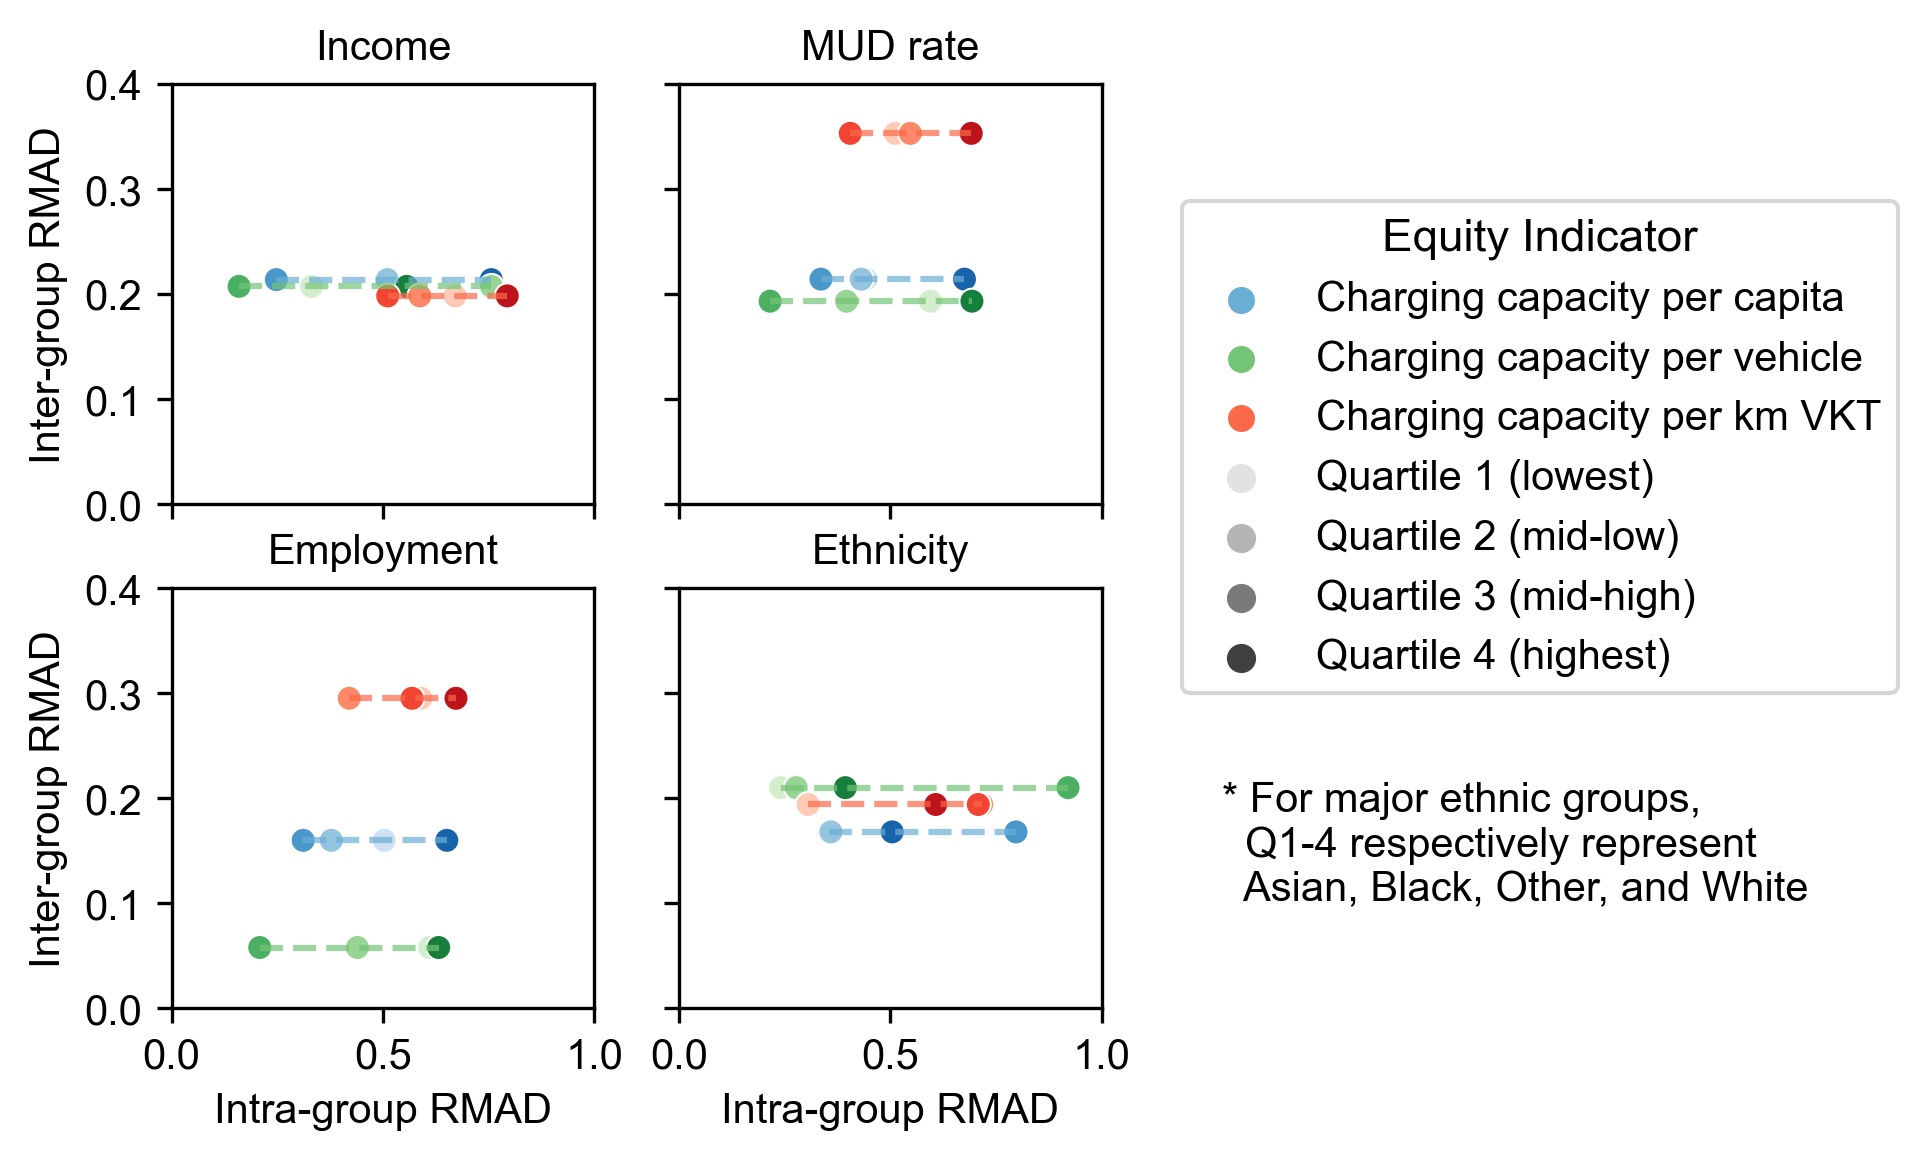

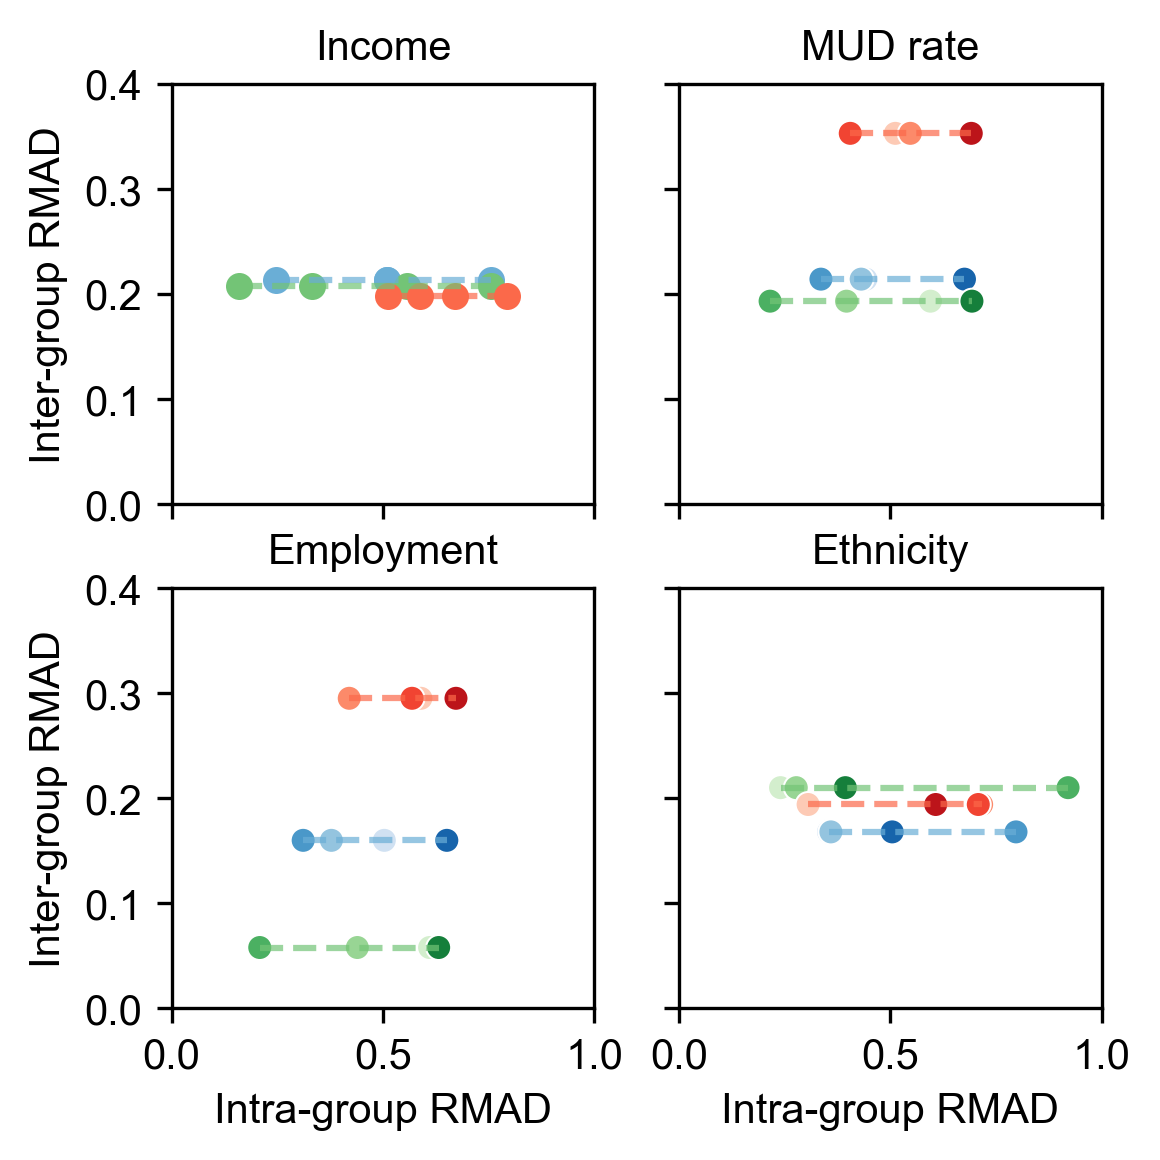

In [ ]:
# plot 4 subplots, separate by demo groups
import copy

# Melt DataFrame to long format
df_melted = df_result.melt(
    id_vars=["equity_indicator", "inter_value", "demographic_group"],
    value_vars=["intra_value_0", "intra_value_1", "intra_value_2", "intra_value_3"],
    var_name="intra_value_type",
    value_name="intra_value_sep",
)

fig, ax = plt.subplots(2, 2, figsize=(4, 4), sharex=True, sharey=True, dpi=300)
ax = ax.ravel()

for i in range(len(demographic_group_list)):
    df_melted_sub = df_melted[df_melted["demographic_group"] == demographic_group_list[i]]
    # Loop through each equity indicator

    for j, group in enumerate(equity_indicator_list):
        group_data = df_melted_sub[df_melted_sub["equity_indicator"] == group]
        palette_i = sns.color_palette(colorlist[j], n_colors=k)

        sns.scatterplot(
            data=group_data,
            x="intra_value_sep",
            y="inter_value",
            hue="intra_value_type",
            palette=palette_i,
            ax=ax[i],
            legend=False,
            label=group,
        )

        x = group_data["inter_value"].values
        y = group_data["intra_value_sep"].values
        x_sort, y_sort = zip(*sorted(zip(x, y)))
        ax[i].plot(
            y_sort, x_sort, linestyle="--", color=sns.color_palette(colorlist[j], n_colors=1).as_hex()[0], alpha=0.7
        )

        ax[i].set_title(demographic_group_list_name[i], fontsize=10)
        ax[i].set_xlabel(f"Intra-group {disparity_index_name}")
        ax[i].set_ylabel(f"Inter-group {disparity_index_name}")


ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 0.4)
ax[0].set_yticks(np.arange(0, 0.5, 0.1))

# manually add legend of four subcategories with 4 shades
palette_grays = sns.color_palette("Greys", n_colors=k)
for i in range(k):
    ax[0].scatter([], [], color=palette_grays[i], label=f"Q{i}")

handles2, labels2 = ax[0].get_legend_handles_labels()
# deep copy
handle1 = copy.deepcopy(handles2)
# change handle colors but not in plot colors
for j, h in enumerate(handle1[:3]):
    h.set_color(sns.color_palette(colorlist[j], n_colors=1))

labels2 = equity_indicator_list_name + [
    "Quartile 1 (lowest)",
    "Quartile 2 (mid-low)",
    "Quartile 3 (mid-high)",
    "Quartile 4 (highest)",
]
plt_text = "* For major ethnic groups, \n  Q1-4 respectively represent \n  Asian, Black, Other, and White"
fig.text(1, 0.2, plt_text, ha="left", fontsize=10)
fig.legend(
    handle1,
    labels2,
    title="Equity Indicator",
    fontsize=10,
    title_fontsize=11,
    loc="upper left",
    bbox_to_anchor=(0.95, 0.8),
    ncol=1,
)

plt.savefig(output_dir + f"equity_scatterplot_{k}group_{disparity_index_name}_by_demo_group.pdf", dpi=300)